# Lab. 4: (Reduced) Variable Neighborhood Search

## Introduction

#### <u>The goal of this laboratory is to compare the behavior of VNS and RVNS on the knapsack 0/1 problem.</u>

You'll have to implement two methods:

- shake(x, k). Try different implementation of the shake method:
  - flip k bits taken randomly in the binary vector x
  - flip max(1, k-1) bits in the binary vector x
  - flip at least k bits in the binary vector x
  - ...
- local_search(f, x)
  - different implementations of VNS use as local search either FirstImprovement or BestImprovement algorithms

---

Getting started: The following cells contain the implementation of the methods that we will use throughout this lab, together with utilities.

**The Knapsack 0/1 problem** is a combinatorial problem that works as follows.

We have a bag with limited capacity L, and we have a set of items  $I=\{i_1,...,i_N\}$  Each  $i_j$  has a given volume $w_{ij}$ and a value $v_{ij}$. The goal of the optimization problem is to fill the bag with a combination of items $S$ such that the combination maximizes the total value contained by the bag while complaining with the constraint on the capacity.

In this version of the knapsack problem we can either discard or carry (at most 1) item. Thus, the search space is $\{0,1\}^{|I|}$ .

Since this is a maximization problem, we can turn it into a minimization problem by returning the opposite of the value. If a solution is not feasible (i.e., exceeds the maximum volume) the function will return a score of 0 (like an empty bag).


Assume
$$ N = \text{number of items} $$
$$ X = \{x_1, x_2, \dots, x_N\} = \text{set of items} $$
$$ v_i = \text{value of item } x_i $$
$$ w_i = \text{weight of item } x_i $$
$$ W = \text{maximum weight the knapsack can hold} $$


Then the 0/1 knapsack problem can be formulated as follows:

\begin{equation*}
  \begin{array}{lr@{}c@{}r@{}l}
    \text{maximize }   &S = \sum_{x_i \in X} v_i x_i \\
    \text{subject to } & \sum_{x_i \in X} w_i x_i \leq W \\
                       & x_i \in \{0, 1\} \forall x_i \in X \\
  \end{array}
\end{equation*}

In [1]:
from matplotlib import pyplot as plt
class Knapsack_0_1:

    def __init__(self):
        self._items = [
            {'name': 'apple', 'value': 1, 'volume': 2},
            {'name': 'pear', 'value': 2, 'volume': 2},
            {'name': 'banana', 'value': 2, 'volume': 2},
            {'name': 'watermelon', 'value': 5, 'volume': 10},
            {'name': 'orange', 'value': 3, 'volume': 2},
            {'name': 'avocado', 'value': 3, 'volume': 2},
            {'name': 'blueberry', 'value': 3, 'volume': 1},
            {'name': 'coconut', 'value': 4, 'volume': 3},
            {'name': 'cherry', 'value': 2, 'volume': 1},
            {'name': 'apricot', 'value': 1, 'volume': 1},
        ]
        self._BAG_CAPACITY = 10
        self.history = []
        self.values = []

    def _get_value(self, solution):
        cur_cap = self._BAG_CAPACITY
        cur_val = 0
        for i, v in enumerate(solution):
            if v == 1:
                cur_val += self._items[i]['value']
                cur_cap -= self._items[i]['volume']
            if cur_cap < 0:
                return 0
        return -cur_val

    def __call__(self, solution):
        value = self._get_value(solution)
        self.history.append(solution)
        self.values.append(value)
        return value

    def trend(self):
        plt.figure()
        plt.plot(self.values)
        plt.show()

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
import copy
import random


def shake(x, k):
    """
    Implements the shaking step for the VNS algorithm. It generates a random x' contained in the neighborhood k of x

    - x: starting point from which the neighborhood is created
    - k: the neighborhood distance (1 for the nearest, 2 for a slightly bigger neighborhood, and so on)

    Returns:
    - The random x' sampled from the neighborhood
    """
    #print(x,k)
    # To be implemented
    # Must: use copy.deepcopy(x) to work on copies of x
    xp = copy.deepcopy(x)
    for i in range(k):
        index = random.randint(0, len(x) - 1)
        if xp[index] == 0:
            xp[index] = 1
        else:
            xp[index] = 0
        
    return xp


def move_or_not(f, x, xs, k):
    if f(xs) < f(x) and f(xs) >= -10:
        x = xs
        k = 1
    else:
        k += 1
    return x, k

def local_search(f, x, method):
    """
    Implements the local search step for the VNS algorithm. It search for a better x' in the neighborhood

    - f: function to minimize
    - x: starting point of the local search

    Returns:
    - The improved x'
    """
    # To be implemented
    # Must: use copy.deepcopy(x) to work on copies of x
    best = copy.deepcopy(x)
    if method == 'BestImprovment':
        xp = copy.deepcopy(x)
        for i in range(len(xp)):
            tmp = copy.deepcopy(xp)
            if xp[i] == 1:
                xp[i] = 0
            else:
                xp[i] = 1
            if f(xp) < f(x) and f(xp)> -10 :
                print(f'sono entrato nel if e sto cambiando il valore, xp è: {xp}, \t il suo valore è: {f(xp)}')
                best = xp
            else:
                xp = tmp
        x = best
    elif method == 'FirstImprovment':
        xp = copy.deepcopy(x)
        for i in range(len(xp)):
            if xp[i] == 1:
                xp[i] = 0
            else:
                xp[i] = 1
            if f(xp) < f(x)  and f(xp)> -10 and f(x)> -10:
                print(f'sono entrato nel if e sto cambiando il valore, xp è: {xp}, \t il suo valore è: {f(xp)}')
                x = xp
                break
            else: 
                xp = x
    return x


def vns(f, x0, kmax, method):
    """
    Seeks for the minimum of the function by means of the Variable Neighborhood
    Search algorithm.

    :f: the function to optimize
    :x0: the initial point
    :kmax: the max number of iterations for each neighborhood
    """
    n = 0
    x = np.array(x0, float)
    best = x
    bestval = f(x)
    k = 0
    #method = 'BestImprovment'
    while k < kmax:
        print('k: \t', k)
        print(f'x inzio ciclo: {x} \t valore di x: {f(x)}')
        xp = x
        if method == 'BestImprovmentNoShake':
            xs = local_search(f, x, method)
            print(f'x post local search: {xs} \t valore di x: {f(xs)}')
        else:
            xp = shake(x, k)
            print(f'x shake: {xp} \t valore di x: {f(xp)}')
            xs = local_search(f, xp, method)
            print(f'x post local search: {xs} \t valore di x: {f(xs)}')
        
        x, k = move_or_not(f, x, xs, k)
        print(f'x post move or not: {x} \t valore di x: {f(x)}')

        # Store the best
        curval = f(x)
        if curval < bestval:
            bestval = curval
            best = x
    return best


def rvns(f, x0, kmax):
    """
    Seeks for the minimum of the function by means of the Reduced Variable
    Neighborhood Search algorithm.

    :f: the function to optimize
    :x0: the initial point
    :kmax: the max number of iterations for each neighborhood
    """
    n = 0
    x = np.array(x0, float)
    best = x
    bestval = f(x)

    k = 0
    while k < kmax:
        print('k: \t', k)
        xp = shake(x, k)
        print(f'x shake: {xp} \t valore di x: {f(xp)}')
        x, k = move_or_not(f, x, xp, k)
        print(f'x post move or not: {x} \t valore di x: {f(x)}')
    return best

# Variable Neighborhood Search
---
## Questions:
- how does the starting point influence the search process?

The impact of the starting point can vary depending on the specific characteristics of the optimization problem and the chosen VNS variant (Best Improvement or First Improvement).

 In the Best Improvement variant, the algorithm selects the best solution within the current neighborhood at each iteration. In this case, the starting point can significantly influence the search process because it determines the initial neighborhood and the quality of the solutions explored. If the starting point is close to a high-quality solution, the algorithm may converge more quickly, requiring fewer iterations to reach the optimum. On the other hand, if the starting point is far from good solutions, the algorithm may require more iterations to explore the search space effectively and converge to the optimum, while, for the First Improvement variant, the starting point does not impact a lot on the quality of the search. this happen because the algorithm accepts the first neighboring solution that improves upon the current solution without necessarily selecting the best one. 

- how does the kmax parameter affect the quality of the result?

 A higher value of kmax allows for greater exploration of the search space. With larger neighborhood sizes, the algorithm can consider a broader range of candidate solutions at each iteration, increasing the likelihood of discovering diverse regions of the search space, and reduces the algorithm's dependency on the starting point. This is particularly advantageous when the initial solution is not close to the global optimum.
 However, increasing kmax also comes with computational costs, as exploring larger neighborhoods requires more computational resources and may increase the runtime of the algorithm.

- how does the generation of the neighborhood (for the shaking) affect:
    - quality of the search?
    - speed of the search?

    The presence of the shake function introduces randomness into the generation of neighboring solutions during the shaking phase. This randomness can help in escaping local optima and exploring diverse regions of the search space. By introducing randomness, especially when kmax (the maximum neighborhood size) is small, the shake function can improve the quality of the search by facilitating the generation of better solutions. Random perturbations allow the algorithm to explore new regions of the search space that may contain better solutions, improving the overall quality of the search.
    It can also accelerate the search process by facilitating the escape from local optima and enabling the algorithm to explore promising regions more efficiently.
    The presence of the "shake" function becomes particularly crucial, especially when the kmax parameter is low and with the BestImprovment variant. in particular, the algorithm may find itself trapped in local minima and generate the same set of solutions repeatedly. The lack of diversity in the explored solutions limits the algorithm's ability to effectively explore the solution space and find better solutions.

In [3]:
dio = Knapsack_0_1()
prova = [0] * len(dio._items)
prova[-3] = 1
prova[3] = 1
print(prova)
dio(prova)

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


0

In [4]:
[0] * len(dio._items)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

kamx: 	 3




starting point: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
x shake: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -1
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -3
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -5
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.], 	 il suo valore è: -8
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.], 	 il suo valore è: -9
x post local search: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x post move or not: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
k: 	 1
x inzio ciclo: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x shake: [1. 1. 1. 0. 0. 0. 0.

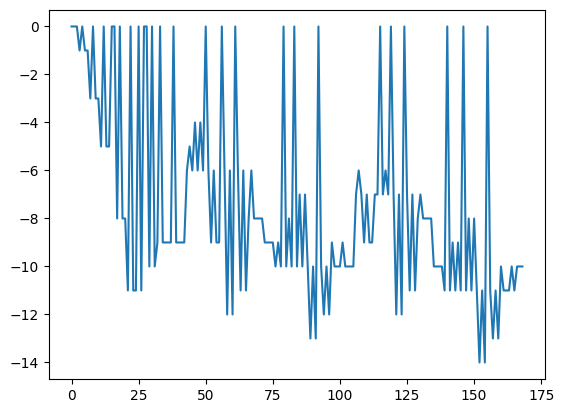

starting point: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
x shake: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -1
x post local search: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
x post move or not: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
k: 	 1
x inzio ciclo: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
x shake: [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x post local search: [1. 1. 0. 1. 1. 1. 1. 1. 1. 1.] 	 valore di x: 0
x post move or not: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
k: 	 2
x inzio ciclo: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
x shake: [1. 1. 0. 1. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
x post local search: [1. 0. 1. 0. 1. 1. 1. 1. 1. 1.] 	 valore di x: 0
x post move or not: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
best: 

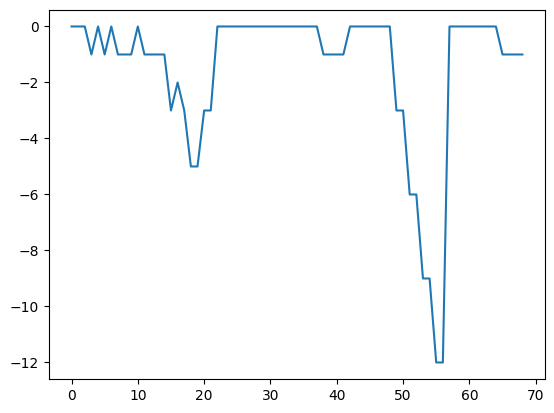

starting point: [0, 0, 0, 1, 1, 0, 0, 1, 1, 1], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post local search: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 1
x inzio ciclo: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x shake: [0. 0. 0. 1. 1. 0. 1. 1. 1. 1.] 	 valore di x: 0
x post local search: [0. 0. 0. 1. 1. 0. 1. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 2
x inzio ciclo: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post local search: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
best: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.], 	 value: 0




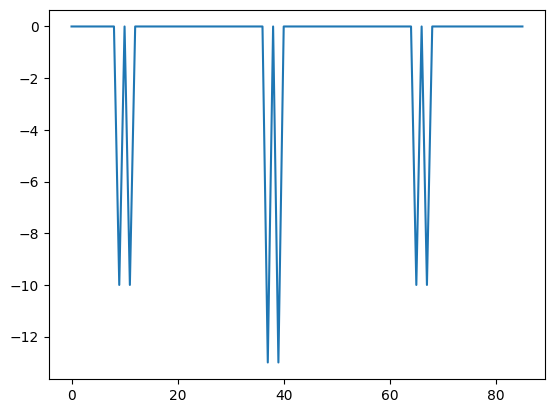

starting point: [0, 0, 0, 1, 1, 0, 0, 1, 1, 1], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post local search: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
x post move or not: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
k: 	 1
x inzio ciclo: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
x shake: [0. 1. 1. 0. 0. 1. 1. 1. 0. 0.] 	 valore di x: -14
x post local search: [0. 0. 0. 1. 1. 0. 0. 0. 1. 1.] 	 valore di x: 0
x post move or not: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
k: 	 2
x inzio ciclo: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
x shake: [0. 0. 1. 0. 0. 1. 1. 0. 0. 1.] 	 valore di x: -9
x post local search: [0. 1. 0. 1. 1. 0. 0. 1. 1. 0.] 	 valore di x: 0
x post move or not: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
best: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.], 	 value: -10




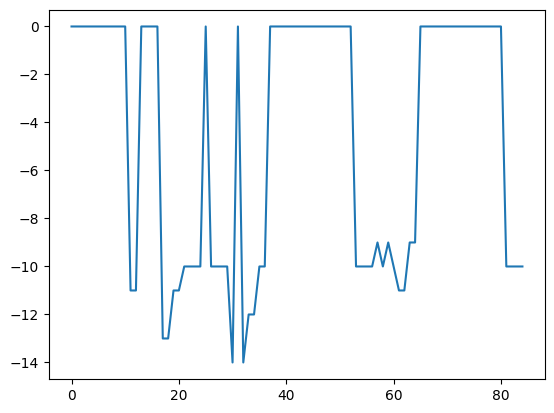

starting point: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
x shake: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.], 	 il suo valore è: -8
x post local search: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
x post move or not: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 1
x inzio ciclo: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
x shake: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
x post local search: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
x post move or not: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 2
x inzio ciclo: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
x shake: [1. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -11
x post local search: [1. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -11
x post move or not: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x

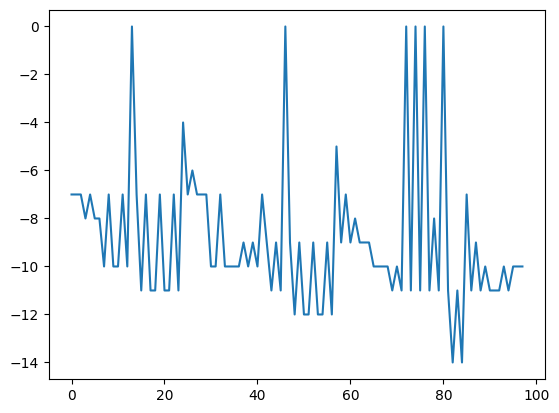

starting point: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
x shake: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.], 	 il suo valore è: -8
x post local search: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
x post move or not: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
k: 	 1
x inzio ciclo: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
x shake: [1. 0. 1. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
x post local search: [1. 1. 0. 1. 1. 1. 1. 0. 0. 0.] 	 valore di x: 0
x post move or not: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
k: 	 2
x inzio ciclo: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
x shake: [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 	 valore di x: -5
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 1. 0. 1.], 	 il suo valore è: -6
x post local search: [1. 0. 0. 0. 

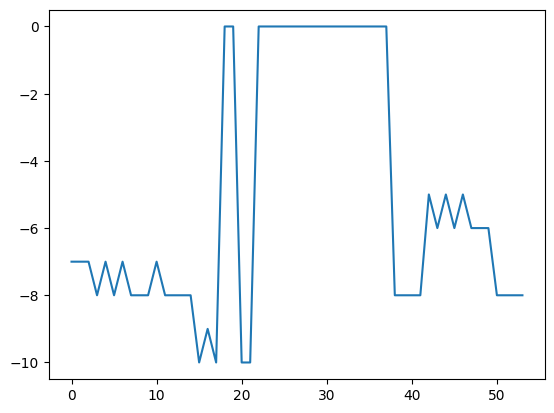

starting point: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
x shake: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -3
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -5
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.], 	 il suo valore è: -8
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.], 	 il suo valore è: -9
x post local search: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x post move or not: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
k: 	 1
x inzio ciclo: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x shake: [1. 0. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -7
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.], 	 il 

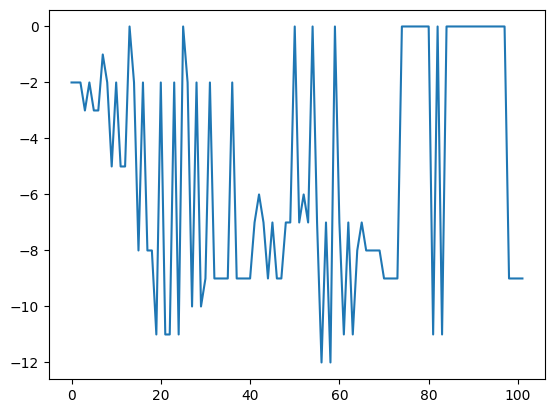

starting point: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
x shake: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -3
x post local search: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x post move or not: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
k: 	 1
x inzio ciclo: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x shake: [1. 1. 0. 0. 0. 0. 0. 0. 1. 0.] 	 valore di x: -5
x post local search: [1. 0. 1. 1. 1. 1. 1. 1. 0. 1.] 	 valore di x: 0
x post move or not: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
k: 	 2
x inzio ciclo: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x shake: [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -4
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -5
x post local search: [1. 1. 1. 0. 0

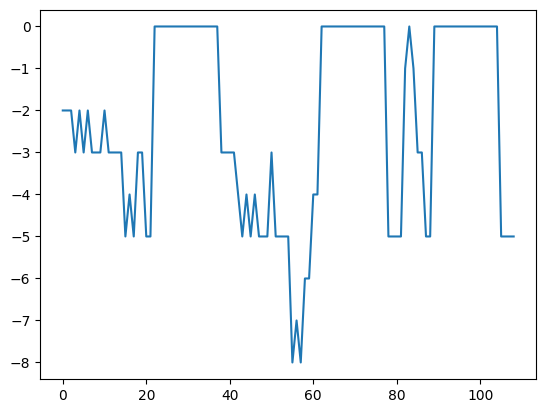

kamx: 	 6




starting point: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
x shake: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -1
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -3
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -5
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.], 	 il suo valore è: -8
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.], 	 il suo valore è: -9
x post local search: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x post move or not: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
k: 	 1
x inzio ciclo: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x shake: [1. 1. 0. 0. 1. 0. 0.

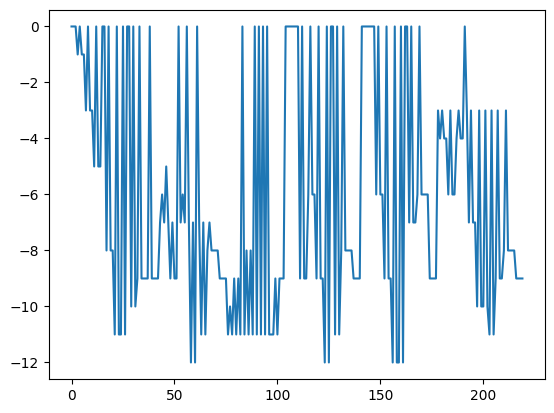

starting point: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
x shake: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -1
x post local search: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
x post move or not: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
k: 	 1
x inzio ciclo: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
x shake: [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 	 valore di x: -4
x post local search: [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.] 	 valore di x: 0
x post move or not: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
k: 	 2
x inzio ciclo: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
x shake: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 	 valore di x: -4
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.], 	 il suo valore è: -5
x post local search: [1. 0. 0. 0. 0. 

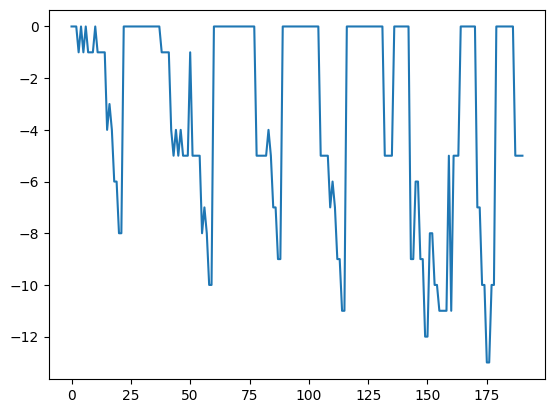

starting point: [0, 0, 0, 1, 1, 0, 0, 1, 1, 1], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post local search: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 1
x inzio ciclo: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x shake: [0. 0. 0. 1. 0. 0. 0. 1. 1. 1.] 	 valore di x: 0
sono entrato nel if e sto cambiando il valore, xp è: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.], 	 il suo valore è: -7
sono entrato nel if e sto cambiando il valore, xp è: [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.], 	 il suo valore è: -3
sono entrato nel if e sto cambiando il valore, xp è: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], 	 il suo valore è: -1
x post local search: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 2
x inzio ciclo: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di 

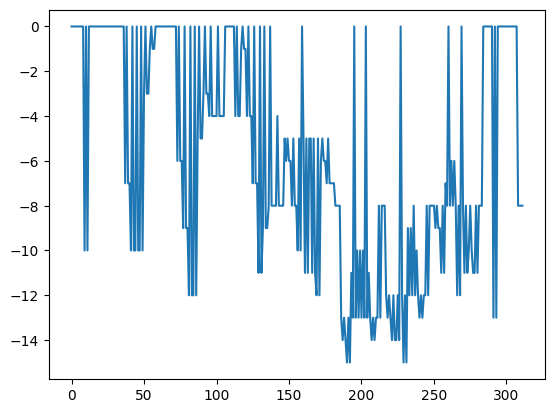

starting point: [0, 0, 0, 1, 1, 0, 0, 1, 1, 1], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post local search: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
x post move or not: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
k: 	 1
x inzio ciclo: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
x shake: [0. 1. 1. 0. 0. 1. 1. 0. 0. 1.] 	 valore di x: -11
x post local search: [0. 0. 0. 1. 1. 0. 0. 1. 1. 0.] 	 valore di x: 0
x post move or not: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
k: 	 2
x inzio ciclo: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
x shake: [1. 1. 1. 0. 0. 1. 0. 0. 0. 0.] 	 valore di x: -8
x post local search: [1. 0. 0. 1. 1. 0. 1. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
k: 	 3
x inzio ciclo: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
x shake: [1. 1. 1. 1. 1. 1. 1. 0.

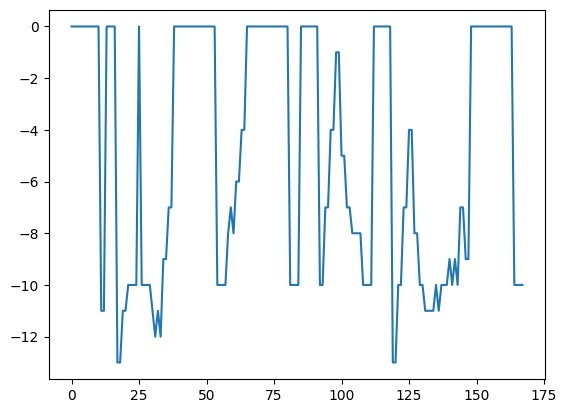

starting point: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
x shake: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.], 	 il suo valore è: -8
x post local search: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
x post move or not: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 1
x inzio ciclo: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
x shake: [1. 1. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 1. 0. 0. 0. 1. 1.], 	 il suo valore è: -9
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 1. 0. 0. 0. 0. 1.], 	 il suo valore è: -7
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 1. 0. 0. 0. 0. 0.], 	 il suo valore è: -6
x post local search: [1. 1. 0. 0. 1. 0. 0. 0. 0. 0.] 	 valore di x: -6
x post move or not

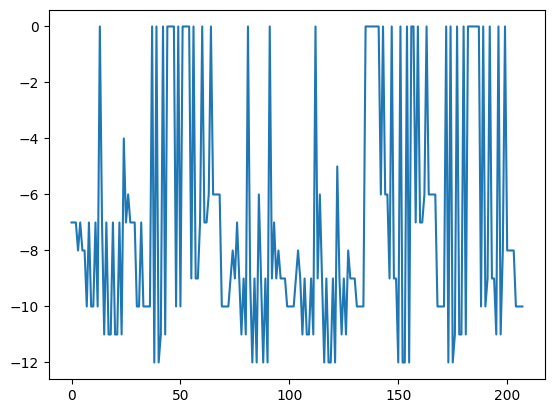

starting point: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
x shake: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.], 	 il suo valore è: -8
x post local search: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
x post move or not: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
k: 	 1
x inzio ciclo: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
x shake: [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 	 valore di x: -11
x post local search: [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] 	 valore di x: 0
x post move or not: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
k: 	 2
x inzio ciclo: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
x shake: [1. 1. 0. 0. 0. 1. 0. 1. 1. 1.] 	 valore di x: 0
x post local search: [1. 0. 1. 1. 1. 0. 1. 0. 0. 0.] 	 valore di x: 0
x post move or not: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
k: 

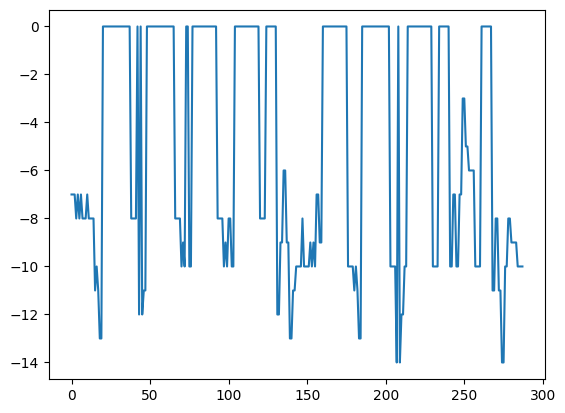

starting point: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
x shake: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -3
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -5
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.], 	 il suo valore è: -8
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.], 	 il suo valore è: -9
x post local search: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x post move or not: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
k: 	 1
x inzio ciclo: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x shake: [1. 1. 1. 1. 1. 0. 0. 0. 0. 1.] 	 valore di x: 0
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.], 	 il s

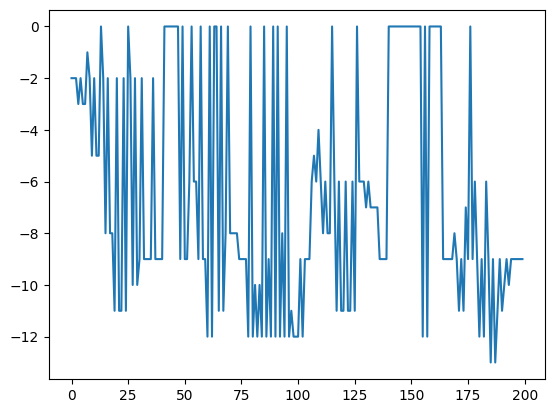

starting point: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
x shake: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -3
x post local search: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x post move or not: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
k: 	 1
x inzio ciclo: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x shake: [1. 1. 0. 0. 0. 0. 0. 1. 0. 0.] 	 valore di x: -7
x post local search: [1. 0. 1. 1. 1. 1. 1. 0. 1. 1.] 	 valore di x: 0
x post move or not: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
k: 	 2
x inzio ciclo: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x shake: [1. 1. 0. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -7
x post local search: [1. 0. 1. 1. 0. 1. 1. 1. 1. 0.] 	 valore di x: 0
x post move or not: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
k: 

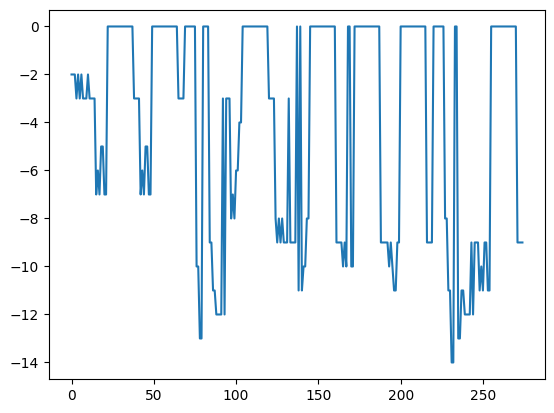

kamx: 	 9




starting point: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
x shake: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -1
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -3
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -5
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.], 	 il suo valore è: -8
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.], 	 il suo valore è: -9
x post local search: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x post move or not: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
k: 	 1
x inzio ciclo: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x shake: [1. 1. 1. 0. 0. 0. 0.

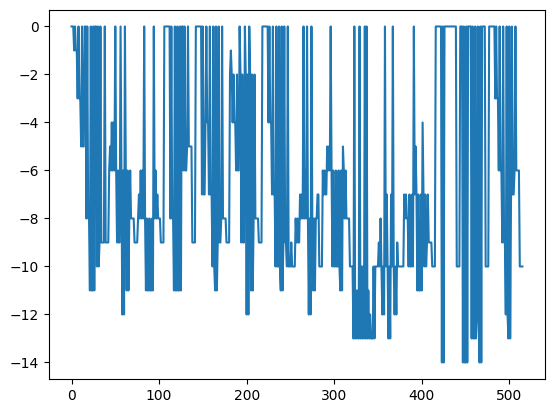

starting point: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
x shake: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -1
x post local search: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
x post move or not: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
k: 	 1
x inzio ciclo: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
x shake: [1. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
sono entrato nel if e sto cambiando il valore, xp è: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -5
x post local search: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 	 valore di x: -5
x post move or not: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 	 valore di x: -5
k: 	 1
x inzio ciclo: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 	 valore di x: -5
x shake: [0. 0. 0. 1. 0. 0. 1. 0. 0. 0.] 	 valore di x: 0
x post local search: [0. 1. 1. 0. 1. 1

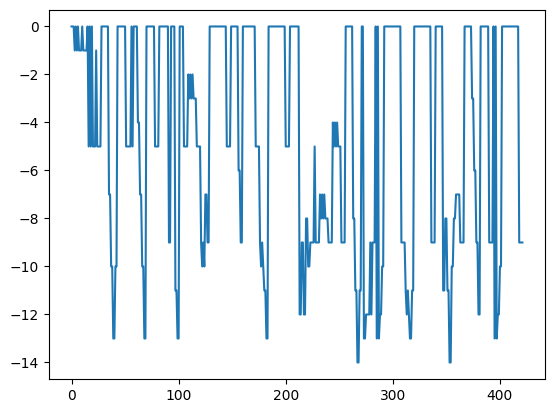

starting point: [0, 0, 0, 1, 1, 0, 0, 1, 1, 1], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post local search: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 1
x inzio ciclo: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x shake: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
x post local search: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
x post move or not: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 1
x inzio ciclo: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post local search: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 2
x inzio ciclo: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
x shake: [0. 1. 1. 0. 1. 0. 0. 1. 1. 1.

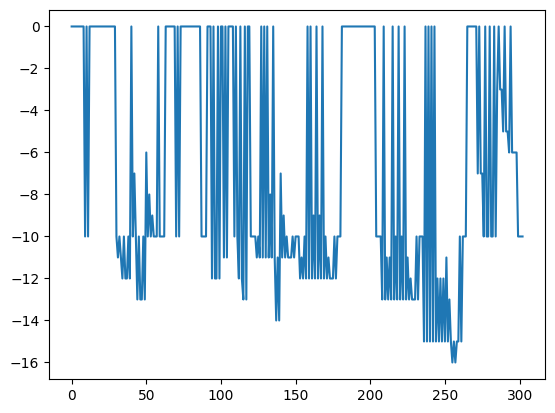

starting point: [0, 0, 0, 1, 1, 0, 0, 1, 1, 1], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post local search: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
x post move or not: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
k: 	 1
x inzio ciclo: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
x shake: [0. 1. 1. 0. 1. 1. 1. 0. 0. 0.] 	 valore di x: -13
x post local search: [0. 0. 0. 1. 0. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
k: 	 2
x inzio ciclo: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
x shake: [0. 1. 1. 0. 0. 1. 0. 0. 1. 0.] 	 valore di x: -9
x post local search: [0. 0. 0. 1. 1. 0. 1. 1. 0. 1.] 	 valore di x: 0
x post move or not: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
k: 	 3
x inzio ciclo: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.] 	 valore di x: -10
x shake: [0. 1. 0. 0. 0. 1. 1. 0.

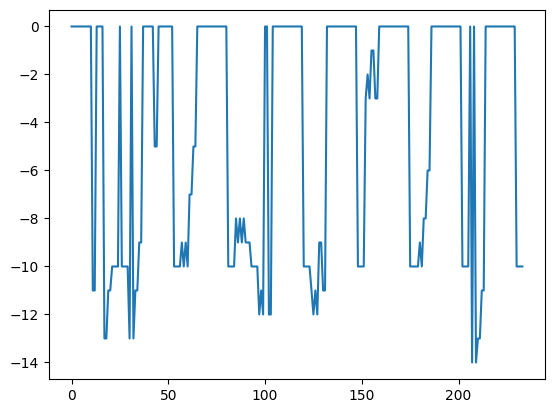

starting point: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
x shake: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.], 	 il suo valore è: -8
x post local search: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
x post move or not: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 1
x inzio ciclo: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
x shake: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
x post local search: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
x post move or not: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 2
x inzio ciclo: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -10
x shake: [1. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -11
x post local search: [1. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -11
x post move or not: [1. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x

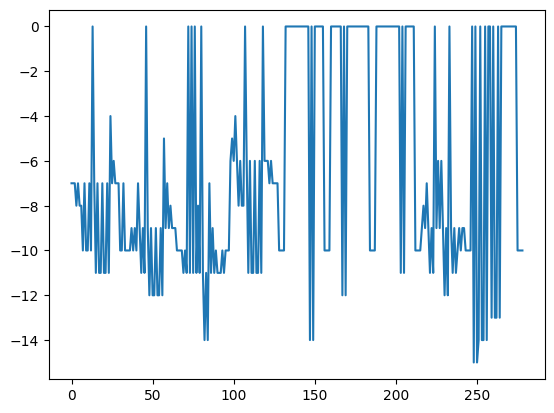

starting point: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
x shake: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
sono entrato nel if e sto cambiando il valore, xp è: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.], 	 il suo valore è: -8
x post local search: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
x post move or not: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
k: 	 1
x inzio ciclo: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
x shake: [1. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 	 valore di x: -11
x post local search: [1. 1. 1. 1. 1. 0. 1. 0. 0. 0.] 	 valore di x: 0
x post move or not: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
k: 	 2
x inzio ciclo: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
x shake: [1. 0. 1. 0. 0. 0. 0. 1. 1. 0.] 	 valore di x: -9
x post local search: [1. 1. 0. 1. 1. 1. 1. 0. 0. 1.] 	 valore di x: 0
x post move or not: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -8
k:

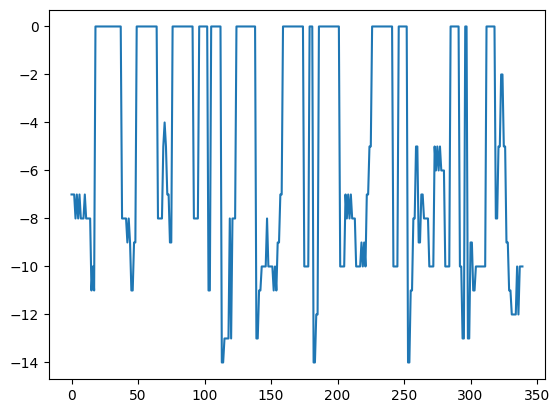

starting point: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: BestImprovment

k: 	 0
x inzio ciclo: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
x shake: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -3
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -5
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.], 	 il suo valore è: -8
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.], 	 il suo valore è: -9
x post local search: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x post move or not: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
k: 	 1
x inzio ciclo: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -9
x shake: [0. 1. 1. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -8
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 1. 0. 1. 0. 0. 0. 0. 1.], 	 il 

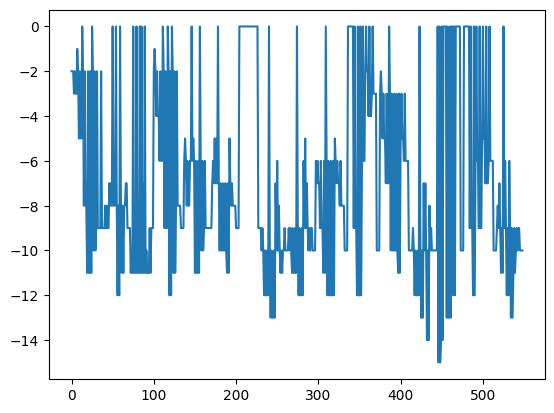

starting point: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 	 method: FirstImprovment

k: 	 0
x inzio ciclo: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
x shake: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
sono entrato nel if e sto cambiando il valore, xp è: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.], 	 il suo valore è: -3
x post local search: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x post move or not: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
k: 	 1
x inzio ciclo: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x shake: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -1
x post local search: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 	 valore di x: 0
x post move or not: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
k: 	 2
x inzio ciclo: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x shake: [1. 1. 0. 1. 0. 1. 0. 0. 0. 0.] 	 valore di x: 0
x post local search: [1. 0. 1. 0. 1. 0. 1. 1. 1. 1.] 	 valore di x: 0
x post move or not: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
k: 	

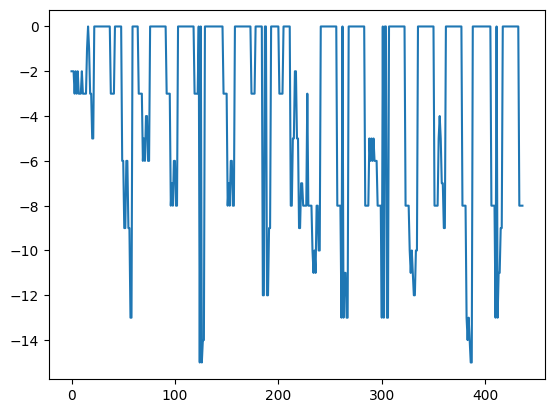

'\n#best improvment con kmax basso e no shake\nmethod = \'BestImprovmentNoShake\'\nkmax = 5\nfor xi in x:\n    func_1 = Knapsack_0_1()\n    print(f"starting point: {xi}, \t method: {method}\n")\n    best = vns(func_1, xi, kmax, method)\n    print(f\'best: {best}, \t value: {func_1(best)}\n\n\')\n    func_1.trend()\n'

In [6]:
x = [[0]*10,[0,0,0,1,1,0,0,1,1,1], [0,0,0,0,0,0,0,1,1,1], [0,1,0,0,0,0,0,0,0,0]]
#x = [[0]*10]
#methods = ["FirstImprovment"]
methods = ["BestImprovment","FirstImprovment"]
kmaxs = [3,6,9]
for kmax in kmaxs:
    print(f'kamx: \t {kmax}\n\n\n\n')
    for xi in x:
        for method in methods:
            if methods[0] == "FirstImprovment":
                func_0 = Knapsack_0_1()
                print(f"starting point: {xi}, \t method: {method}\n")
                best = vns(func_0, xi, kmax, method)
                print(f'best: {best}, \t value: {func_0(best)}\n\n')
                func_0.trend()
            else:
                func_1 = Knapsack_0_1()
                print(f"starting point: {xi}, \t method: {method}\n")
                best = vns(func_1, xi, kmax, method)
                print(f'best: {best}, \t value: {func_1(best)}\n\n')
                func_1.trend()

'''
#best improvment con kmax basso e no shake
method = 'BestImprovmentNoShake'
kmax = 5
for xi in x:
    func_1 = Knapsack_0_1()
    print(f"starting point: {xi}, \t method: {method}\n")
    best = vns(func_1, xi, kmax, method)
    print(f'best: {best}, \t value: {func_1(best)}\n\n')
    func_1.trend()
'''

# Reduced Variable Neighborhood Search
---
## Questions:
- how does the starting point influence the search process?

In Reduced Variable Neighborhood Search (RVNS), the starting point can influence the search process, especially when kmax (the maximum neighborhood size) is low.
When kmax is low, the search process tends to be more localized, meaning that the algorithm focuses on exploring solutions within a limited neighborhood around the starting point. In such cases, the quality of the starting point becomes more important because it determines the initial set of solutions explored by the algorithm.
However, in general, since RVNS does not include a local search phase, the influence of the starting point primarily affects the diversity of the initial solutions rather than the all optimization process.

- how does the kmax parameter affect the quality of the result?

Since RVNS is entirely stochastic, the choice of kmax also affects the variability of the search process: a larger kmax value introduces more randomness into the search process, making it less likely to find the same solution starting from the same point in different runs. This randomness can be beneficial for exploring diverse regions of the solution space but may require more computational resources to converge to a satisfactory solution. Is need to baalce the trade-off between exploration and exploitation to achieve the best possible results.
If the starting point is a good point, a lower kmax could perform well. 

- how does the generation of the neighborhood affect:
    - quality of the search?
    - velocity of the search?

The quality of the search is not very high as the solutions are completely random. In fact, it can be seen that with bad starting points (where the value is zero) and with a low kmax, better solutions cannot be found. This happens because randomly changing a single value of the vector x can lead to solutions similar to the initial one and more perturbation is needed to find better situations, but with a low kmax the iterations may not be sufficient.
Furthermore, being based almost entirely on stochastic processes, given the same initial point, the set of solutions can be highly variable. 
The fact that it does not perform a local search allows the algorithm to be very fast.

- how does RVNS compare to VNS?

RVNS introduces greater randomness compared to VNS by skipping the local search phase entirely and directly accepting a randomly chosen solution generated by the shake function (if the move_or_not function accepts it). By bypassing local search, RVNS relies solely on the shaking phase to explore the solution space, which can lead to a wider exploration of diverse regions but without the refinement provided by local optimization.
RVNS is generally faster than VNS because it skips the local search phase, which can be computationally intensive. With sufficiently large values of kmax, RVNS can still find solutions of good quality, but ha s a lower quality respect to the VNS. Abd also the quality of the solutions in RVNS can vary a lot due to its greater variability in its results compared to VNS, which is more deterministic.






starting point: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 	 kmax: 3


k: 	 0
x shake: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
x post move or not: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
k: 	 1
x shake: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
x post move or not: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
k: 	 1
x shake: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.] 	 valore di x: -6
x post move or not: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.] 	 valore di x: -6
k: 	 1
x shake: [0. 0. 1. 0. 0. 1. 0. 1. 0. 0.] 	 valore di x: -9
x post move or not: [0. 0. 1. 0. 0. 1. 0. 1. 0. 0.] 	 valore di x: -9
k: 	 1
x shake: [0. 0. 1. 0. 0. 1. 0. 1. 0. 1.] 	 valore di x: -10
x post move or not: [0. 0. 1. 0. 0. 1. 0. 1. 0. 1.] 	 valore di x: -10
k: 	 1
x shake: [0. 0. 1. 1. 0. 1. 0. 1. 0. 1.] 	 valore di x: 0
x post move or not: [0. 0. 1. 0. 0. 1. 0. 1. 0. 1.] 	 valore di x: -10
k: 	 2
x shake: [0. 0. 1. 0. 0. 1. 0. 0. 1. 1.] 	 valore di x: -8
x post move or not: [0. 0. 1. 0. 0. 1. 0. 1. 0. 1.] 	 valo

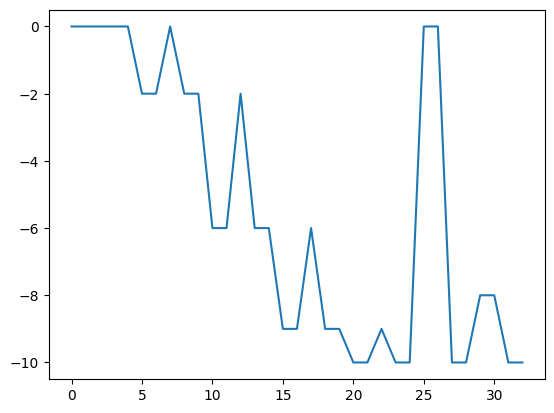

starting point: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 	 kmax: 6


k: 	 0
x shake: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
x post move or not: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
k: 	 1
x shake: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 	 valore di x: -2
x post move or not: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 	 valore di x: -2
k: 	 1
x shake: [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.] 	 valore di x: -4
x post move or not: [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.] 	 valore di x: -4
k: 	 1
x shake: [0. 1. 0. 0. 0. 0. 0. 1. 1. 0.] 	 valore di x: -8
x post move or not: [0. 1. 0. 0. 0. 0. 0. 1. 1. 0.] 	 valore di x: -8
k: 	 1
x shake: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
x post move or not: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
k: 	 1
x shake: [0. 1. 0. 1. 0. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
k: 	 2
x shake: [0. 1. 0. 0. 0. 0. 1. 0. 1. 1.] 	 valore di x: -8
x post move or not: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore 

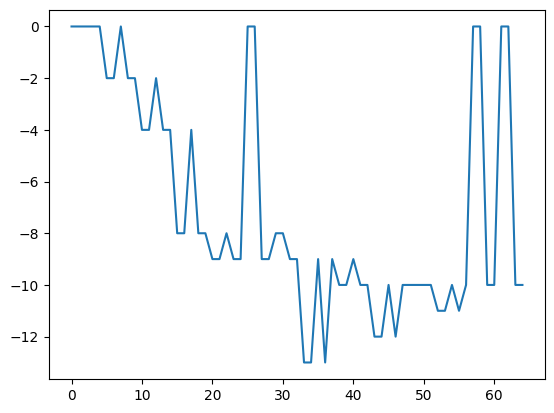

starting point: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 	 kmax: 9


k: 	 0
x shake: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
x post move or not: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: 0
k: 	 1
x shake: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 	 valore di x: -3
x post move or not: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 	 valore di x: -3
k: 	 1
x shake: [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -4
x post move or not: [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -4
k: 	 1
x shake: [0. 1. 0. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -6
x post move or not: [0. 1. 0. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -6
k: 	 1
x shake: [0. 1. 0. 0. 1. 0. 0. 0. 0. 0.] 	 valore di x: -5
x post move or not: [0. 1. 0. 0. 1. 0. 0. 0. 0. 1.] 	 valore di x: -6
k: 	 2
x shake: [0. 1. 0. 0. 1. 0. 0. 0. 1. 0.] 	 valore di x: -7
x post move or not: [0. 1. 0. 0. 1. 0. 0. 0. 1. 0.] 	 valore di x: -7
k: 	 1
x shake: [0. 1. 0. 0. 1. 0. 0. 0. 1. 1.] 	 valore di x: -8
x post move or not: [0. 1. 0. 0. 1. 0. 0. 0. 1. 1.] 	 valore

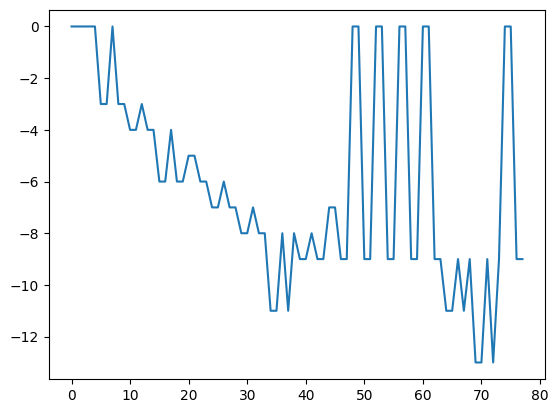

starting point: [0, 0, 0, 1, 1, 0, 0, 1, 1, 1], 	 kmax: 3


k: 	 0
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 1
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 0. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 2
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0


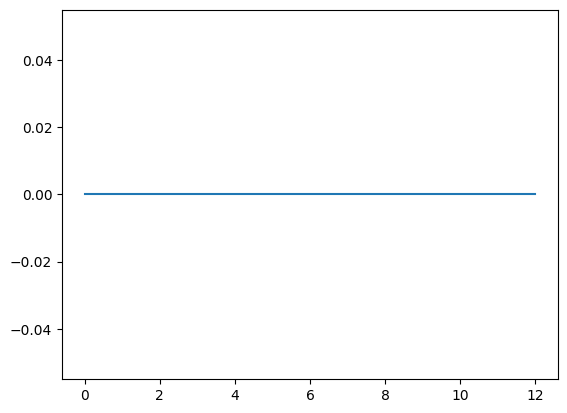

starting point: [0, 0, 0, 1, 1, 0, 0, 1, 1, 1], 	 kmax: 6


k: 	 0
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 1
x shake: [0. 0. 0. 1. 1. 1. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 2
x shake: [0. 0. 0. 1. 0. 0. 0. 1. 0. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 3
x shake: [1. 1. 0. 1. 1. 0. 0. 0. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 4
x shake: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 	 valore di x: -3
x post move or not: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 	 valore di x: -3
k: 	 1
x shake: [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.] 	 valore di x: -5
x post move or not: [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.] 	 valore di x: -5
k: 	 1
x shake: [0. 0. 1. 0. 1. 0. 0. 1. 0. 0.] 	 valore di x: -9
x post move or not: [0. 0. 1. 0. 1. 0. 0. 1. 0. 0.] 	 valore di x:

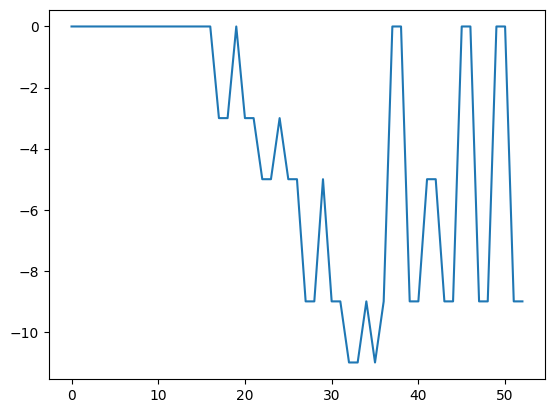

starting point: [0, 0, 0, 1, 1, 0, 0, 1, 1, 1], 	 kmax: 9


k: 	 0
x shake: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 1
x shake: [1. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 2
x shake: [1. 0. 0. 1. 1. 0. 1. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 3
x shake: [0. 1. 0. 1. 1. 0. 0. 0. 1. 0.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 4
x shake: [0. 1. 0. 1. 1. 0. 0. 1. 1. 0.] 	 valore di x: 0
x post move or not: [0. 0. 0. 1. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
k: 	 5
x shake: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
x post move or not: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
k: 	 1
x shake: [0. 1. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -12
x post move or not: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: 

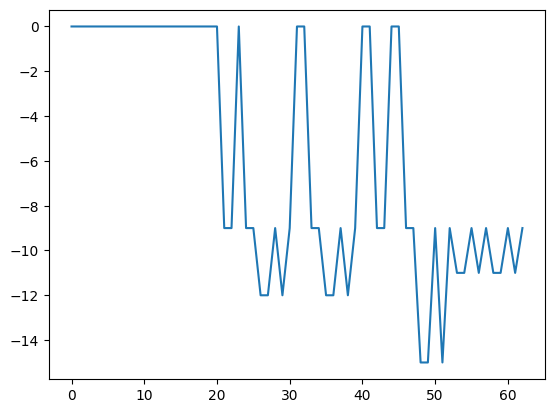

starting point: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 	 kmax: 3


k: 	 0
x shake: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
x post move or not: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
k: 	 1
x shake: [0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 	 valore di x: -10
x post move or not: [0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 1
x shake: [0. 0. 0. 1. 0. 1. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 2
x shake: [0. 0. 1. 0. 1. 1. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 	 valore di x: -10


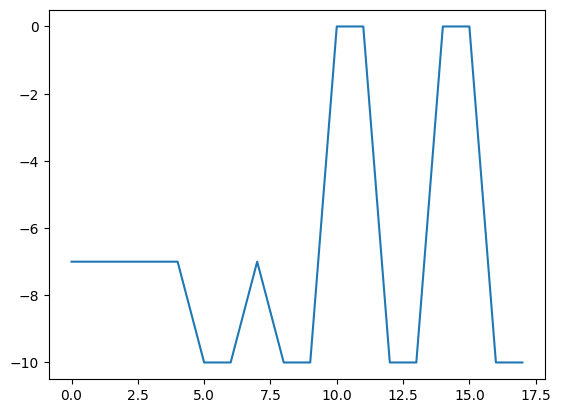

starting point: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 	 kmax: 6


k: 	 0
x shake: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
x post move or not: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
k: 	 1
x shake: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
x post move or not: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 1
x shake: [0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 	 valore di x: -8
x post move or not: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 2
x shake: [0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 	 valore di x: -11
x post move or not: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 3
x shake: [1. 0. 1. 0. 1. 0. 1. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 4
x shake: [0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 	 valore di x: -11
x post move or not: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: -10
k: 	 5
x shake: [0. 1. 0. 0. 1. 0. 1. 1. 0. 1.] 	 valore di x: -13
x post move or not: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1.

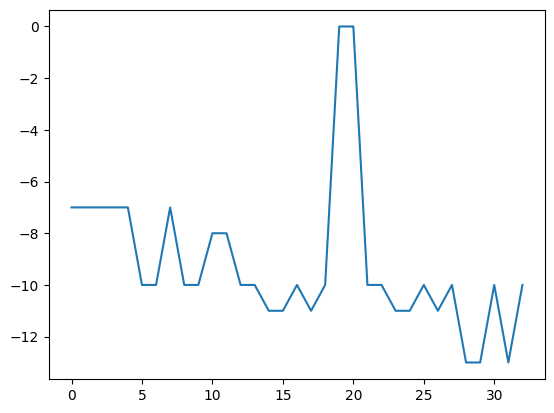

starting point: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 	 kmax: 9


k: 	 0
x shake: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
x post move or not: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -7
k: 	 1
x shake: [0. 0. 1. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
x post move or not: [0. 0. 1. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
k: 	 1
x shake: [0. 0. 1. 1. 0. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 1. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
k: 	 2
x shake: [1. 0. 1. 0. 1. 0. 0. 1. 1. 1.] 	 valore di x: 0
x post move or not: [0. 0. 1. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
k: 	 3
x shake: [1. 0. 1. 0. 1. 0. 0. 0. 1. 1.] 	 valore di x: -9
x post move or not: [0. 0. 1. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
k: 	 4
x shake: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.] 	 valore di x: -5
x post move or not: [0. 0. 1. 0. 0. 0. 0. 1. 1. 1.] 	 valore di x: -9
k: 	 5
x shake: [0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 	 valore di x: -6
x post move or not: [0. 0. 1. 0. 0. 0. 0. 1. 1. 1.] 	 valore

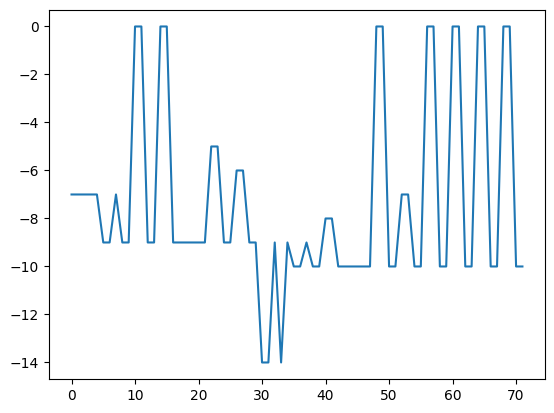

starting point: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 	 kmax: 3


k: 	 0
x shake: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
x post move or not: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
k: 	 1
x shake: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x post move or not: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
k: 	 1
x shake: [1. 1. 0. 0. 0. 0. 0. 0. 0. 1.] 	 valore di x: -4
x post move or not: [1. 1. 0. 0. 0. 0. 0. 0. 0. 1.] 	 valore di x: -4
k: 	 1
x shake: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -3
x post move or not: [1. 1. 0. 0. 0. 0. 0. 0. 0. 1.] 	 valore di x: -4
k: 	 2
x shake: [1. 1. 1. 0. 0. 0. 0. 0. 1. 1.] 	 valore di x: -8
x post move or not: [1. 1. 1. 0. 0. 0. 0. 0. 1. 1.] 	 valore di x: -8
k: 	 1
x shake: [1. 1. 1. 1. 0. 0. 0. 0. 1. 1.] 	 valore di x: 0
x post move or not: [1. 1. 1. 0. 0. 0. 0. 0. 1. 1.] 	 valore di x: -8
k: 	 2
x shake: [0. 1. 1. 0. 0. 0. 1. 0. 1. 1.] 	 valore di x: -10
x post move or not: [0. 1. 1. 0. 0. 0. 1. 0. 1. 1.] 	 valo

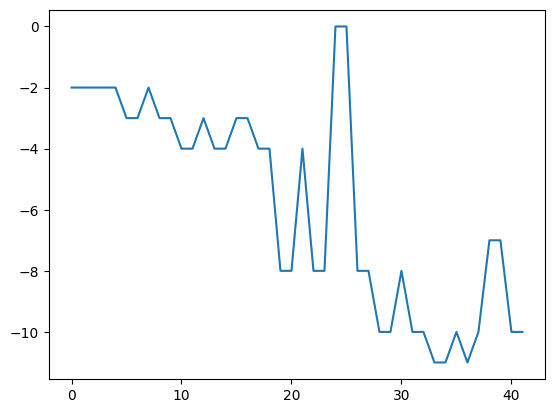

starting point: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 	 kmax: 6


k: 	 0
x shake: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
x post move or not: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
k: 	 1
x shake: [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.] 	 valore di x: -4
x post move or not: [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.] 	 valore di x: -4
k: 	 1
x shake: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 	 valore di x: -2
x post move or not: [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.] 	 valore di x: -4
k: 	 2
x shake: [0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 	 valore di x: -5
x post move or not: [0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 	 valore di x: -5
k: 	 1
x shake: [0. 0. 1. 0. 0. 1. 0. 0. 1. 0.] 	 valore di x: -7
x post move or not: [0. 0. 1. 0. 0. 1. 0. 0. 1. 0.] 	 valore di x: -7
k: 	 1
x shake: [0. 0. 1. 0. 1. 1. 0. 0. 1. 0.] 	 valore di x: -10
x post move or not: [0. 0. 1. 0. 1. 1. 0. 0. 1. 0.] 	 valore di x: -10
k: 	 1
x shake: [0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 	 valore di x: -8
x post move or not: [0. 0. 1. 0. 1. 1. 0. 0. 1. 0.] 	 va

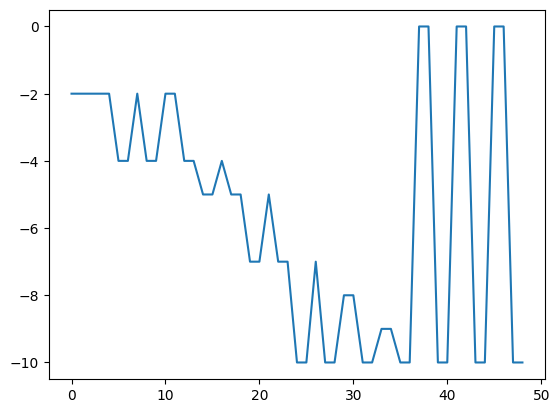

starting point: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 	 kmax: 9


k: 	 0
x shake: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
x post move or not: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 valore di x: -2
k: 	 1
x shake: [0. 1. 0. 0. 1. 0. 0. 0. 0. 0.] 	 valore di x: -5
x post move or not: [0. 1. 0. 0. 1. 0. 0. 0. 0. 0.] 	 valore di x: -5
k: 	 1
x shake: [0. 1. 0. 0. 1. 0. 0. 0. 1. 0.] 	 valore di x: -7
x post move or not: [0. 1. 0. 0. 1. 0. 0. 0. 1. 0.] 	 valore di x: -7
k: 	 1
x shake: [0. 1. 0. 0. 1. 1. 0. 0. 1. 0.] 	 valore di x: -10
x post move or not: [0. 1. 0. 0. 1. 1. 0. 0. 1. 0.] 	 valore di x: -10
k: 	 1
x shake: [0. 1. 0. 0. 1. 1. 1. 0. 1. 0.] 	 valore di x: -13
x post move or not: [0. 1. 0. 0. 1. 1. 0. 0. 1. 0.] 	 valore di x: -10
k: 	 2
x shake: [0. 1. 0. 0. 0. 1. 0. 1. 1. 0.] 	 valore di x: -11
x post move or not: [0. 1. 0. 0. 1. 1. 0. 0. 1. 0.] 	 valore di x: -10
k: 	 3
x shake: [0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 	 valore di x: -8
x post move or not: [0. 1. 0. 0. 1. 1. 0. 0. 1. 0.] 

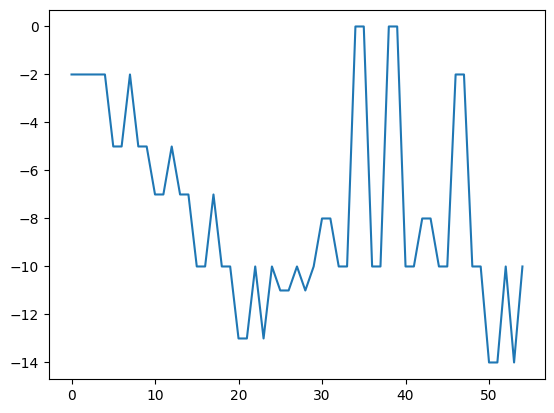

In [9]:
x = [[0]*10,[0,0,0,1,1,0,0,1,1,1], [0,0,0,0,0,0,0,1,1,1], [0,1,0,0,0,0,0,0,0,0]]
kmaxs = [3,6,9]
for xi in x:
    for kmax in kmaxs:
        print(f'starting point: {xi}, \t kmax: {kmax}\n\n')
        func = Knapsack_0_1()
        rvns(func, xi, kmax)
        func.trend()